In [184]:
from sysdata.sim.csv_futures_sim_data import csvFuturesSimData
from paper.systems.simplesystem import simplesystem
import pandas as pd
import numpy as np
from seaborn import heatmap
import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['text.color'] = 'white'
from sysquant.estimators.diversification_multipliers import diversification_mult_single_period
from sysquant.optimisation.weights import portfolioWeights
from syslogdiag.log_to_screen import logtoscreen
import matplotlib.colors as mcolors

log = logtoscreen('csvFuturesSimData')
log.set_logging_level('close eye')
# data = csvFuturesSimData()
data =  csvFuturesSimData(csv_data_paths=dict(
            csvFuturesAdjustedPricesData='ctse.data.adjusted_prices_csv',
            csvFuturesMultiplePricesData='ctse.data.multiple_prices_csv',
            csvFuturesInstrumentData='ctse.data.csvconfig'
    ), log=log)
system = simplesystem(
    data,
    'paper.systems.china.yaml')
data = system.data

2022-11-30 15:54:49 {'type': 'base_system', 'stage': 'config'}  Adding config defaults


2172
2172
2031
2031


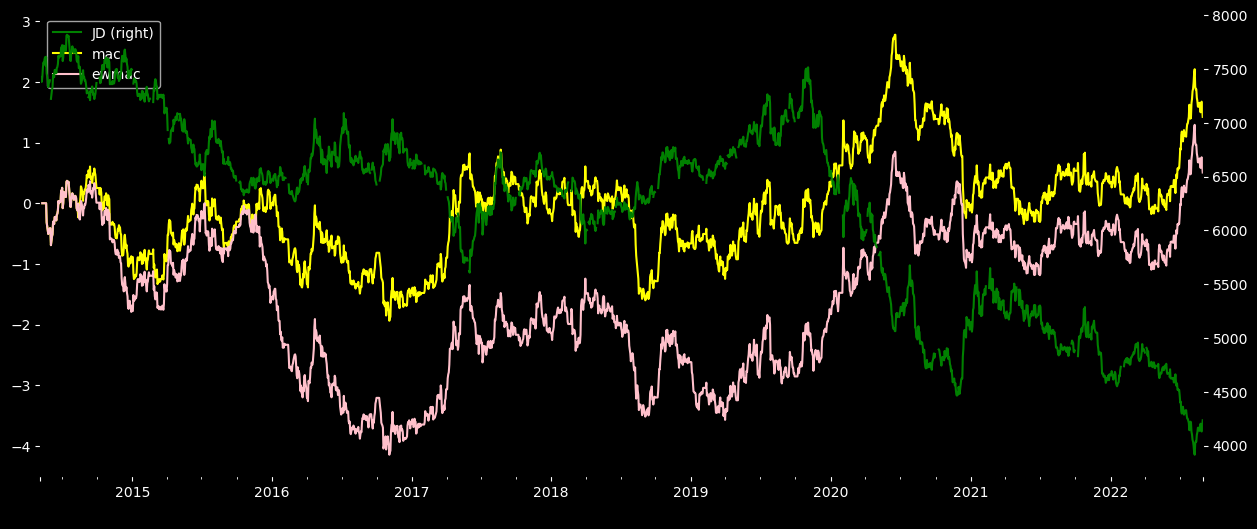

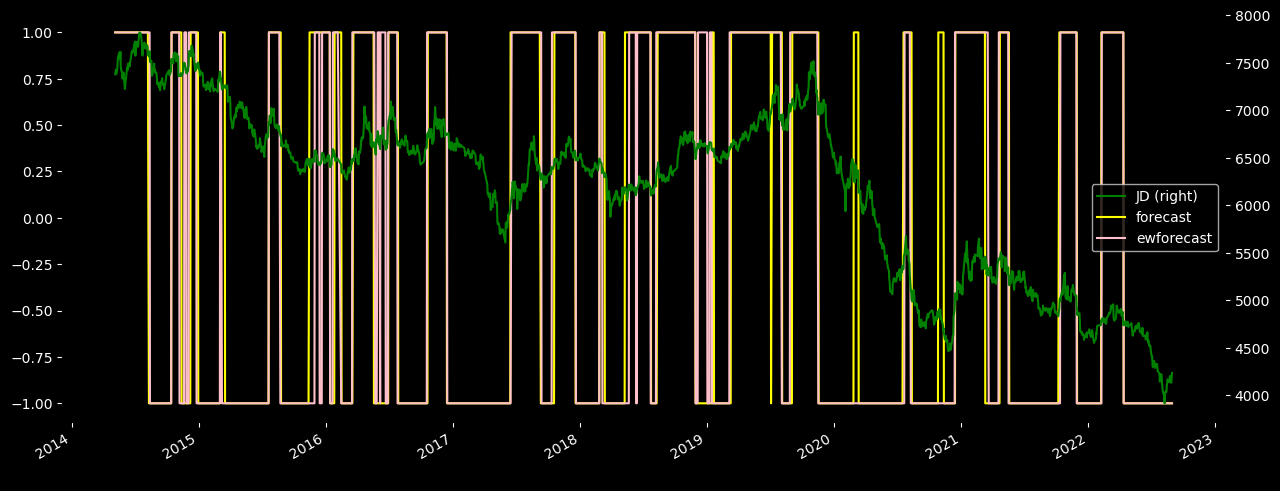

In [16]:
from paper.systems.rules.mac import mac
from paper.systems.rules.mac import ewmac

instrument_code = 'JD'
fast = 10
slow = 4 * fast

price = data.daily_prices(instrument_code).rename(instrument_code).dropna()
forecast = mac(price, fast, slow).rename('forecast')


price = data.daily_prices(instrument_code).rename(instrument_code).dropna()
ewforecast = ewmac(price, fast, slow).rename('ewforecast')

forecast_df = pd.concat([price, forecast, ewforecast], axis=1)
forecast_df = forecast_df.tail(len(forecast_df) - 2 * slow)

from systems.accounts.account_forecast import pandl_for_instrument_forecast

def select(df):
    return df
    # return df[(df.index > '2016-01-01') & (df.index < '2020-01-01')]

account = pandl_for_instrument_forecast(forecast=forecast_df.forecast, price = forecast_df[instrument_code])
ewaccount = pandl_for_instrument_forecast(forecast=forecast_df.ewforecast, price = forecast_df[instrument_code])
print(len(ewaccount))
print(len(account))
print(len(forecast_df[instrument_code]))
print(len(forecast_df.ewforecast))

pl = account.curve().rename('mac')
ewpl = ewaccount.curve().rename('ewmac')
pl_df = pd.concat([forecast_df[instrument_code], pl, ewpl], axis=1)
pl_df = select(pl_df)
ax = pl_df.plot(secondary_y=instrument_code, figsize=(15,6), color=['green', 'yellow', 'pink'])

forecast_df = select(forecast_df)
plt.show()
ax = forecast_df.plot(figsize=(15,6), color=['green', 'yellow', 'pink'], secondary_y=instrument_code)

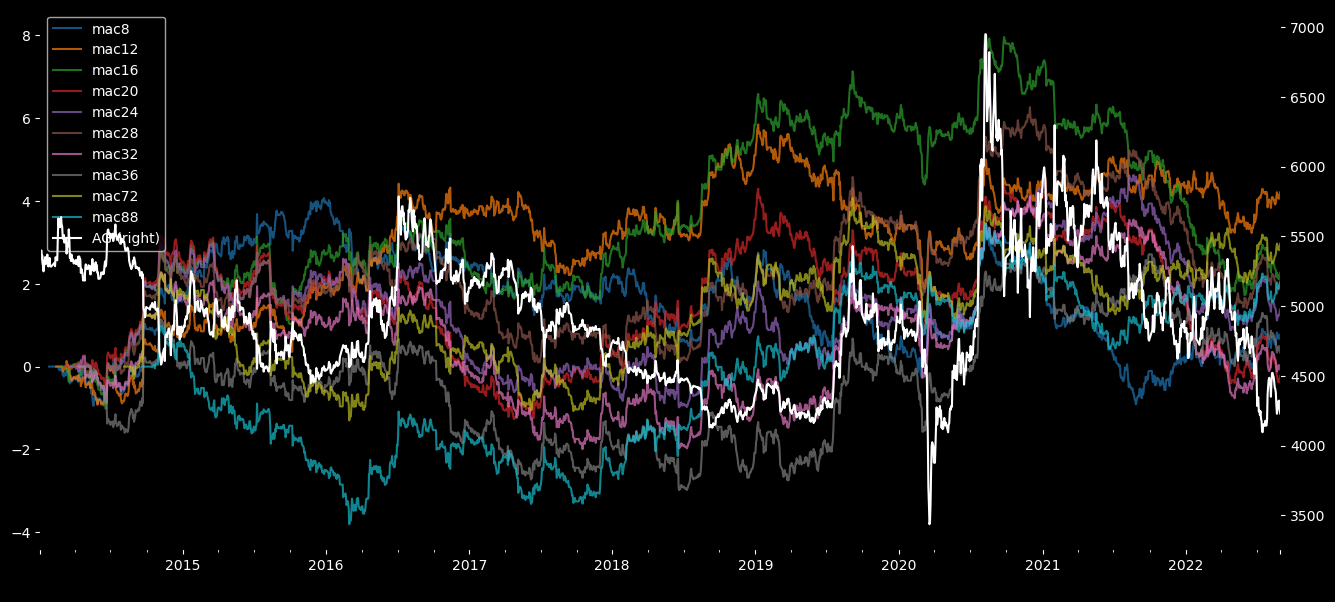

AG


forecast8      5.773114
forecast12     8.922060
forecast16    12.011469
forecast20    15.161966
forecast24    17.702409
forecast28    20.702366
forecast32    24.081225
forecast36    25.860239
forecast72    47.812133
forecast88    58.597905
dtype: float64

In [211]:
from paper.systems.rules.mac import mac
from paper.systems.rules.mac import ewmac
from systems.accounts.account_forecast import pandl_for_instrument_forecast

def select(df):
    return df
    # return df[(df.index > '2016-01-01') & (df.index < '2020-01-01')]

instrument_code = pd.Series(system.get_instrument_list()).sample(1).iloc[0]
instrument_code = 'AG'
fast_range1 = [2, 3, 4, 5, 6, 7, 8, 9, 18, 22]
color_list = list(mcolors.TABLEAU_COLORS.values())
assert len(color_list) >= len(fast_range1)
color_list = color_list[:len(fast_range1)]

pl_df_list = []
forecast_df_list = []
for fast in fast_range1:
    slow = 4 * fast

    price = data.daily_prices(instrument_code).rename(instrument_code).dropna()
    forecast = mac(price, fast, slow).rename('forecast{}'.format(slow))
    forecast_df_list.append(forecast)

    price = data.daily_prices(instrument_code).rename(instrument_code).dropna()
    ewforecast = ewmac(price, fast, slow).rename('ewforecast')

    forecast_df = pd.concat([price, forecast, ewforecast], axis=1)
    forecast_df = forecast_df.tail(len(forecast_df) - 2 * slow)

    account = pandl_for_instrument_forecast(forecast=forecast_df['forecast{}'.format(slow)], price = forecast_df[instrument_code])
    # ewaccount = pandl_for_instrument_forecast(forecast=forecast_df.ewforecast, price = forecast_df[instrument_code])
    # print(len(ewaccount))
    # print(len(account))
    # print(len(forecast_df[instrument_code]))
    # print(len(forecast_df.ewforecast))

    pl = account.curve().rename('mac{}'.format(slow))
    # ewpl = ewaccount.curve().rename('ewmac{}'.format(slow))
    pl_df_list.append(pl)
    
ax = plt.subplot()
pl_df_list = pd.concat(pl_df_list, axis=1)
pl_df_list = select(pl_df_list)
_ = pl_df_list.plot(secondary_y=instrument_code, ax=ax, figsize=(16,7), color=color_list, alpha=0.7)
# forecast_df = select(forecast_df[instrument_code])

price = data.daily_prices(instrument_code).rename(instrument_code).dropna()
price = select(price)
price.plot(ax=ax, secondary_y=True, legend=True, color='white')
plt.show()

turnover = pd.concat(forecast_df_list, axis=1)
trades = ((turnover.replace(np.nan, 0).diff() != 0) * 1).sum()
years = np.abs((turnover.apply(lambda se:se.first_valid_index()) - turnover.last_valid_index()) / pd.Timedelta(365, 'D'))
avg_hold_days = 12 * 4 * 5 / (trades / years)
print(instrument_code)
display(avg_hold_days)


In [206]:
len(fast_range1)

12

<AxesSubplot:>

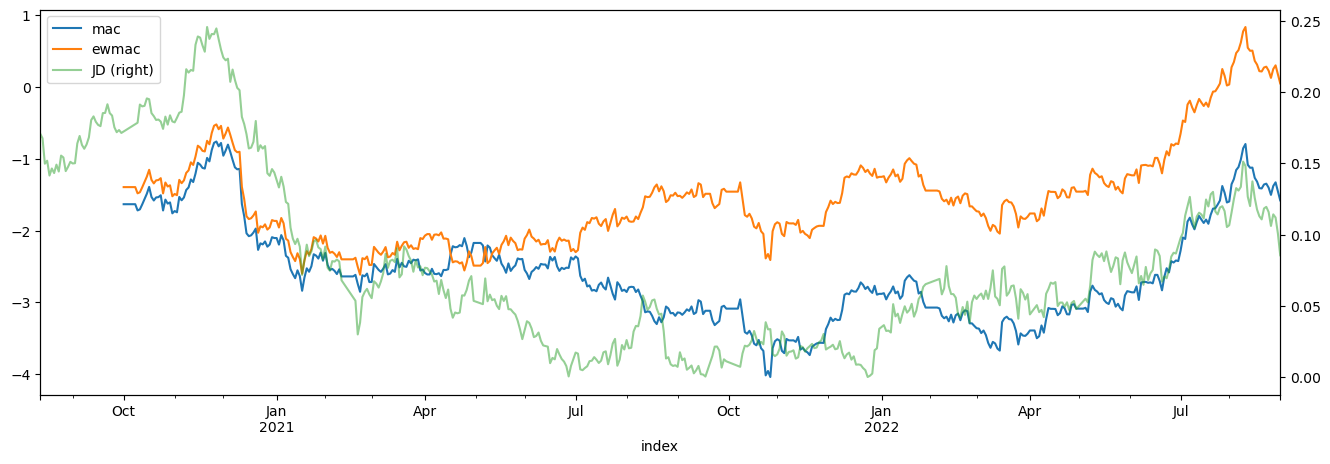

In [4]:
pl.tail(500).plot(legend=True, figsize=(16,5))
ewpl.tail(500).plot(legend=True)
# price.head(500).plot(legend=True, secondary_y=True)

from mdi import rolling_snr
snr = rolling_snr(price.ffill(), slow)
snr.tail(500).plot(legend=True, secondary_y=True, alpha=0.5)